<a href="https://colab.research.google.com/github/MahmutRuzi/photonics-sim-examples/blob/main/torcwa_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
torch.cuda.is_available()

True

In [17]:
!nvidia-smi

Fri Dec 23 08:57:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip3 install torcwa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torcwa
print(torcwa.__version__)

0.1.3


In [5]:
import numpy as np

In [6]:
%cd /content/drive/MyDrive/torcwa-runs/

/content/drive/MyDrive/torcwa-runs


In [7]:
!ls

Au_disk_v1-1.py		      materials		 torcwa-test1.ipynb
Au_nanobar_L870W230H70_v1.py  Si_nanodisk_v1.py
colab_Au-nanobar_v1.ipynb     Si_nanodisk_v2.py


In [8]:
refrat_cSi = np.genfromtxt("./materials/Au_Olmen2012.csv", delimiter=',',skip_header=1, unpack=True)

In [10]:
def eps_cSi(lamba0):
    # lamba0 should be in um
    n_interp = np.interp(lamba0, refrat_cSi[0,::], refrat_cSi[1,:])
    k_interp = np.interp(lamba0, refrat_cSi[0,::], refrat_cSi[2,:])
    epsr = n_interp**2-k_interp**2
    epsi = 2*n_interp*k_interp
    eps_cSi = epsr+1.0j*epsi
    return eps_cSi

#%%

In [12]:
lamba=10000./np.array([1250,1300,1350,1400,1450,1500,1550,1580,1600,1610,1620,1630,1640,1645,1650,1655,1660,1665,1670,1675,1680,1690,1700,1720,1750,1800,1850])

In [13]:
lamba.dtype

dtype('float64')

In [18]:
sim_dtype = torch.complex64
geo_dtype = torch.float32
device = torch.device('cuda')

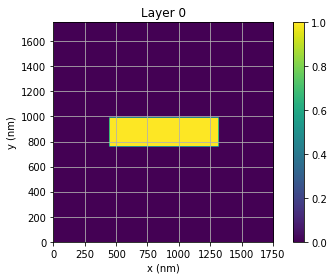

In [19]:
import matplotlib.pyplot as plt
# geometry
L = [1750, 1750]            # nm / nm
torcwa.rcwa_geo.dtype = geo_dtype
torcwa.rcwa_geo.device = device
torcwa.rcwa_geo.Lx = L[0]
torcwa.rcwa_geo.Ly = L[1]
torcwa.rcwa_geo.nx = 1750
torcwa.rcwa_geo.ny = 1750
torcwa.rcwa_geo.grid()
torcwa.rcwa_geo.edge_sharpness = 1000.

x_axis = torcwa.rcwa_geo.x.cpu()
y_axis = torcwa.rcwa_geo.y.cpu()
#z_axis = z.cpu()

# layers
Lx = 870. # length along the X axis, in nm
Ly = 230. # width along the y axis, in nm
layer0_geometry = torcwa.rcwa_geo.rectangle(Wx=Lx,Wy=Ly,Cx=L[0]/2.,Cy=L[1]/2.)
layer0_thickness = 70.

#%%
# View layers
plt.figure(2)
plt.imshow(torch.transpose(layer0_geometry,-2,-1).cpu(),origin='lower',extent=[x_axis[0],x_axis[-1],y_axis[0],y_axis[-1]])
plt.title('Layer 0')
plt.xlim([0,L[0]])
plt.xlabel('x (nm)')
plt.ylim([0,L[1]])
plt.ylabel('y (nm)')
plt.colorbar()
plt.grid()
plt.tight_layout()


In [21]:
# Generate and perform simulation
import time
start_time = time.time()
order_Nx = 10 # Fourier truncation order
order_Ny = 5
order = [order_Nx,order_Ny]
lamb0 = torch.tensor(1000*lamba,dtype=geo_dtype,device=device) #Wavelength in nm
#%%
# Simulation environment
# light
start_time = time.time()
inc_ang = 0.*(np.pi/180)    # radian
azi_ang = 0.*(np.pi/180)    # radian
substrate_eps = 3.41**2
input_eps = 1**2
txx = []
rxx = []
for lamb0_ind in range(len(lamb0)):
    lamb0_now = lamb0[lamb0_ind]
    print('Wavelength: {:g}'.format(lamb0_now))
    sim = torcwa.rcwa(freq=1/lamb0_now,order=order,L=L,dtype=sim_dtype,device=device)
    #sim.add_input_layer(eps=input_eps)
    sim.add_output_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    silicon_eps = eps_cSi(lamb0_now.cpu()/1000)
    layer0_eps = layer0_geometry*silicon_eps + (1.-layer0_geometry)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()
    rxx.append(sim.S_parameters(orders=[0,0],direction='forward',port='reflection',polarization='xx',ref_order=[0,0]))
    txx.append(sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0]))
txx = torch.cat(txx)
rxx = torch.cat(rxx)
print("--- %s seconds ---" % (time.time() - start_time))


Wavelength: 8000
Wavelength: 7692.31
Wavelength: 7407.41
Wavelength: 7142.86
Wavelength: 6896.55
Wavelength: 6666.67
Wavelength: 6451.61
Wavelength: 6329.11
Wavelength: 6250
Wavelength: 6211.18
Wavelength: 6172.84
Wavelength: 6134.97
Wavelength: 6097.56
Wavelength: 6079.03
Wavelength: 6060.61
Wavelength: 6042.3
Wavelength: 6024.1
Wavelength: 6006.01
Wavelength: 5988.02
Wavelength: 5970.15
Wavelength: 5952.38
Wavelength: 5917.16
Wavelength: 5882.35
Wavelength: 5813.95
Wavelength: 5714.29
Wavelength: 5555.56
Wavelength: 5405.41
--- 10.252070665359497 seconds ---


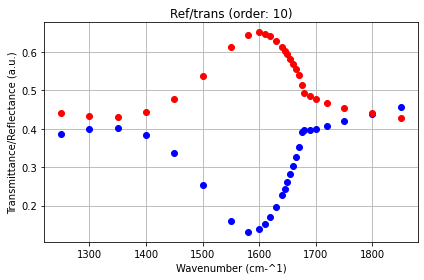

In [22]:
plt.figure(3)
plt.plot(1e7/lamb0.cpu(),torch.abs(txx).cpu()**2,'bo',1e7/lamb0.cpu(),torch.abs(rxx).cpu()**2,'ro')
#plt.plot(lamb0.cpu()/1000,torch.abs(txx).cpu()**2,'b')
plt.title('Ref/trans (order: '+str(order_Nx)+')')
plt.xlabel('Wavenumber (cm-^1)')
plt.ylabel('Transmittance/Reflectance (a.u.)')
plt.grid()
plt.tight_layout()